In [147]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gpflow
from gpflow.utilities import print_summary, positive
plt.style.use('ggplot')
%matplotlib inline
import tensorflow as tf
import math
from tensorflow import math as tm
from sklearn import preprocessing
from scipy.interpolate import interp1d

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability import mcmc

PI = tf.constant(math.pi, dtype='float64')

In [2]:
# np.set_printoptions(threshold=np.inf)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# k_exp.D[2] = 1.2849
# k_exp.D[3] = 1.0959
# k_exp.lengthscale.assign(1.4110)
# k_exp.h(2, 3).numpy()


# Replication of the paper by Lawrence et al., 2006

https://papers.nips.cc/paper/3119-modelling-transcriptional-regulation-using-gaussian-processes.pdf

#### Probesets

The original paper restricted their interest to 5 known targets of p53: 
- DDB2 -------------- (probeset 203409_at)
- p21 ----------------- (probeset 202284_s_at) (alias p21CIP1, CDKN1A)
- SESN1/hPA26 -- (probeset 218346_s_at)
- BIK ----------------- (probeset 205780_at)
- TNFRSF10b ----- (probeset 209294_x_at, 209295_at, 210405_x_at)

In [3]:
mmgmos_processed = True
if mmgmos_processed:
    with open('barencoPUMA_exprs.csv', 'r') as f:
        df = pd.read_csv(f, index_col=0)
    with open('barencoPUMA_se.csv', 'r') as f:
        dfe = pd.read_csv(f, index_col=0)
    columns = [f'cARP1-{t}hrs.CEL' for t in np.arange(7)*2]

else:
    with open('barenco_processed.tsv', 'r') as f:
        df = pd.read_csv(f, delimiter='\t', index_col=0)
    display(df.head(5))
    columns = [f'H_ARP1-{t}h.3' for t in np.arange(7)*2]

known_target_genes = ['203409_at', '202284_s_at', '218346_s_at', '205780_at', '209295_at']
genes = df[df.index.isin(known_target_genes)][columns]
genes_se = dfe[dfe.index.isin(known_target_genes)][columns]


In [4]:
assert df[df.duplicated()].size == 0

### Probeset Combination

TNFRSF10b has multiple probesets (probeset 209294_x_at, 209295_at, 210405_x_at) which should be combined.

It can be observed below that the log intensities have a similar pattern. Thus a popular way to combine is to take the average of the log intensities.

[1.086096572, 3.1600259160000004, 5.5508273610000005, 5.262909097, 4.809493267, 3.9572317439999996, 3.885223145]
[3.9494367280000002, 7.283146992000001, 8.395333295, 8.14746491, 8.456766284, 7.370946042999999, 7.409659157]
[-0.141718886, 1.204829083, 5.13730302, 5.0618756760000005, 5.064913861, 3.150539124, 2.115912072]


c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


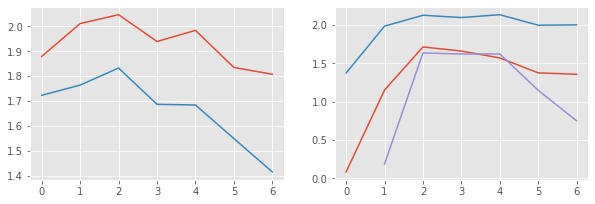

In [5]:

plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
p53 = df[df.index.isin(['211300_s_at', '201746_at'])][columns].astype(float)
for index, row in p53.iterrows():
    p53.loc[index] = np.log(list(row))
    plt.plot(list(row))

p53_mean = pd.Series(p53.mean(0), index=genes.columns, name='p53')

plt.subplot(2,2,2)
TNFRSF10b = df[df.index.isin(['209294_x_at', '209295_at', '210405_x_at'])][columns]
for index, row in TNFRSF10b.iterrows():
    print(list(row))
    TNFRSF10b.loc[index] = np.log(list(row))
    plt.plot(list(row))

TNFRSF10b_mean = pd.Series(TNFRSF10b.mean(0), index=genes.columns, name='TNFRSF10b')

In [6]:
index ={
    '203409_at': 'DDB2', 
    '202284_s_at': 'p21',
    '218346_s_at': 'SESN1',
    '205780_at': 'BIK',
    '209295_at': 'TNFRSF10b'
}
genes.rename(index=index, inplace=True)
genes_se.rename(index=index, inplace=True)

# genes = genes.append(TNFRSF10b_mean, ignore_index=False)
genes = genes.append(p53_mean, ignore_index=False).astype(np.float64)
#print(genes.loc[genes['Scan REF'] == pd.nan, 'Scan REF'])# = 'test'
display(genes)
display(genes_se)


,cARP1-0hrs.CEL,cARP1-2hrs.CEL,cARP1-4hrs.CEL,cARP1-6hrs.CEL,cARP1-8hrs.CEL,cARP1-10hrs.CEL,cARP1-12hrs.CEL
p21,1.268160,7.375613,9.600847,8.485615,8.134573,7.045323,7.171770
DDB2,7.593549,9.122439,10.192915,10.154778,10.103455,9.529804,9.567770
BIK,2.905667,6.756250,8.154665,8.222898,8.074595,7.026262,7.001658
TNFRSF10b,3.949437,7.283147,8.395333,8.147465,8.456766,7.370946,7.409659
SESN1,6.354029,7.703226,8.818485,8.608104,8.803210,7.860224,7.981910
p53,1.801008,1.887280,1.939142,1.812769,1.833809,1.692203,1.611795


,cARP1-0hrs.CEL,cARP1-2hrs.CEL,cARP1-4hrs.CEL,cARP1-6hrs.CEL,cARP1-8hrs.CEL,cARP1-10hrs.CEL,cARP1-12hrs.CEL
p21,2.587364,0.557080,0.216786,0.326715,0.392748,0.624041,0.566781
DDB2,0.249263,0.137954,0.092652,0.092837,0.095946,0.117834,0.111057
BIK,1.835773,0.605828,0.346498,0.308507,0.331839,0.524867,0.503841
TNFRSF10b,0.939674,0.230524,0.146372,0.156875,0.140932,0.222533,0.209342
SESN1,0.322529,0.185634,0.117371,0.124440,0.117990,0.170974,0.155030


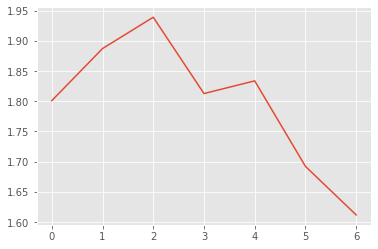

In [7]:
plt.plot(genes[genes.index == 'p53'].values[0])

### Setup data

In [18]:
num_genes = 5 #X.shape[1]
num_times = 7
scaler = preprocessing.StandardScaler()
training_genes = genes[genes.index != 'p53'].values
training_genes_se = genes_se[genes_se.index != 'p53'].values


Y_var = training_genes_se*training_genes_se
Y = np.exp(training_genes+Y_var/2)
Y_var = (np.exp(Y_var)-1) * np.exp(2*training_genes + Y_var)

scale = np.sqrt(np.var(Y, axis=1));
scale_mat = np.c_[[scale for _ in range(7)]].T
Y = Y / scale_mat
Y_var = Y_var / (scale_mat * scale_mat)

Y_orig_shape = Y.shape
Y = Y.reshape(-1, 1)
Y_var = Y_var.reshape(-1, 1)
Sigma = tf.linalg.tensor_diag(Y_var.reshape(-1))

Y_f = genes[genes.index == 'p53'].values[0].reshape(-1, 1)
# Y = scaler.fit_transform(Y)
X = np.arange(num_times, dtype='float64')*2
X = np.c_[[X for _ in range(num_genes)]].reshape(-1)
print(X)
print(Y[:8])
print(X.shape,Y.shape)

[ 0.  2.  4.  6.  8. 10. 12.  0.  2.  4.  6.  8. 10. 12.  0.  2.  4.  6.
  8. 10. 12.  0.  2.  4.  6.  8. 10. 12.  0.  2.  4.  6.  8. 10. 12.]
[[0.02128189]
 [0.39278111]
 [3.1869369 ]
 [1.07648558]
 [0.77601276]
 [0.29368458]
 [0.32209943]
 [0.23514879]]
(35,) (35, 1)


### Model

We fix the sensitivity of p21 to be 1, and decay to be 0.8 as in Barenco et al.

            K_xx = np.zeros([X.shape[0],X.shape[0]], dtype='float64')
            print(K_xx.shape)
            for j in range(num_genes):
                for k in range(num_genes):
                    K_xx[j*block_size:(j+1)*block_size, 
                         k*block_size:(k+1)*block_size] = self.k_xx(j, k, X)
            return K_xx


In [141]:
class ExpressionKernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0])
        self.lengthscale = gpflow.Parameter(1.0, transform=positive())
#         B = tf.ones(5)
#         self.B = gpflow.Parameter(B)
#         self.D = gpflow.Parameter(np.random.uniform(0.5, 1, 5), transform=positive())
#         S = tf.ones(5)
        D_affine = tfb.AffineScalar(shift=tf.cast(0.1, tf.float64),
                                    scale=tf.cast(1.5-0.1, tf.float64))
        D_sigmoid = tfb.Sigmoid()
        D_logistic = tfb.Chain([D_affine, D_sigmoid])
        S_affine = tfb.AffineScalar(shift=tf.cast(0.1, tf.float64),
                                    scale=tf.cast(3.-0.1, tf.float64))
        S_sigmoid = tfb.Sigmoid()
        S_logistic = tfb.Chain([S_affine, S_sigmoid])

        self.D = [gpflow.Parameter(np.random.uniform(1, 1), transform=S_logistic, dtype=tf.float64) for _ in range(num_genes)]
        self.D[0].trainable = False
        self.D[0].assign(0.8)

        self.S = [gpflow.Parameter(np.random.uniform(1, 1), transform=S_logistic, dtype=tf.float64) for _ in range(num_genes)]
        self.S[0].trainable = False
        self.S[0].assign(1)
        
        
    def K(self, X, X2=None):
        self.block_size = int(X.shape[0]/num_genes)
        interp = interp1d(np.arange(Y_var.shape[0]), Y_var.reshape(-1), kind='linear')
        Sigma = interp(np.linspace(0,Y_var.shape[0]-1, X.shape[0]))
        Sigma = tf.linalg.tensor_diag(Sigma)
        if X2 is None:
            shape = [X.shape[0],X.shape[0]]
            K_xx = tf.zeros(shape, dtype='float64')
            for j in range(num_genes):
                for k in range(num_genes):
                    mask = np.ones(shape)
                    other = np.zeros(shape)
                    mask[j*self.block_size:(j+1)*self.block_size, 
                         k*self.block_size:(k+1)*self.block_size] = 0
                    
                    pad_top = j*self.block_size
                    pad_left = k*self.block_size
                    pad_right = 0 if k == num_genes-1 else shape[0]-self.block_size-pad_left
                    pad_bottom = 0 if j == num_genes-1 else shape[0]-self.block_size-pad_top
                    other = tf.pad(self.k_xx(j, k),
                                   tf.constant([
                                       [pad_top,pad_bottom],
                                       [pad_left,pad_right]
                                   ]), 'CONSTANT'
                                  )
#                     print(j, k, pad_right, pad_bottom, other.shape)
                    K_xx = K_xx * mask + other * (1 - mask)


            return K_xx + Sigma
        else:
            print('K not none K_xf\n')
            shape = [X.shape[0],self.block_size]
            K_xf = tf.zeros(shape, dtype='float64')
            for j in range(num_genes):
                mask = np.ones(shape)
                other = np.zeros(shape)
                mask[j*self.block_size:(j+1)*self.block_size] = 0
                other[j*self.block_size:(j+1)*self.block_size] = self.k_xf(j, X)

                K_xf = K_xf * mask + other * (1-mask) 
            return K_xf
        

    def gamma(self, k):
        return self.D[k]*self.lengthscale/2

    def h(self, k, j, primefirst=True):
        l = self.lengthscale
#         print(l, self.D[k], self.D[j])
        t_prime, t, t_dist = self.get_distance_matrix(primefirst=primefirst, size=self.block_size)
        multiplier = tm.exp(self.gamma(k)**2) / (self.D[j]+self.D[k])
        first_erf_term = tm.erf(t_dist/l - self.gamma(k)) + tm.erf(t/l + self.gamma(k))
        second_erf_term = tm.erf(t_prime/l - self.gamma(k)) + tm.erf(self.gamma(k))
        return multiplier * (tf.multiply(tm.exp(-tm.multiply(self.D[k],t_dist)) , first_erf_term) - \
                             tf.multiply(tm.exp(-tm.multiply(self.D[k],t_prime)-tm.multiply(self.D[j],t)) , second_erf_term))
    

    def k_xx(self, j, k):
        '''k_xx(t, tprime)'''
        mult = self.S[j]*self.S[k]*self.lengthscale*0.5*tm.sqrt(PI)
        return mult*(self.h(k, j) + self.h(j, k, primefirst=False))


    def get_distance_matrix(self, primefirst=True, size=7):
        t = tf.cast(tf.range(size)*2, tf.float64)
        t_ = tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]])
        t_prime = tf.transpose(tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]]))
        if not primefirst:
            t_prime = tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]])
            t_ = tf.transpose(tf.reshape(tf.tile(t, [size]), [ size, tf.shape(t)[0]]))

        return t_prime, t_, t_prime-t_
    
    def k_xf(self, j, X):
        t_prime, t_, t_dist = self.get_distance_matrix(size=self.block_size)
        l = self.lengthscale
        erf_term = tm.erf(t_dist/l - self.gamma(j)) + tm.erf(t_/l + self.gamma(j))
        
        return self.S[j]*l*0.5*tm.sqrt(PI)*tm.exp(self.gamma(j))**2 *tm.exp(-self.D[j]*t_dist)*erf_term

    def K_diag(self, X):
        print('k_diag')

        """I've used the fact that we call this method for K_ff when finding the covariance as a hack so
        I know if I should return K_ff or K_xx. In this case we're returning K_ff!!
        $K_{ff}^{post} = K_{ff} - K_{fx} K_{xx}^{-1} K_{xf}$"""
        _,_,t_dist = self.get_distance_matrix(size=X.shape[0])
        K_ff = tf.math.exp(-(t_dist**2)/(self.lengthscale**2))
        return tf.linalg.tensor_diag_part(K_ff)


k_exp = ExpressionKernel()
print_summary(k_exp, fmt='notebook')

name,class,transform,trainable,prior,shape,dtype
ExpressionKernel.lengthscale,Parameter,Softplus,True,(),float64,1
ExpressionKernel.D[0],Parameter,Chain,False,(),float64,0.8
ExpressionKernel.D[1],Parameter,Chain,True,(),float64,1
ExpressionKernel.D[2],Parameter,Chain,True,(),float64,1
ExpressionKernel.D[3],Parameter,Chain,True,(),float64,1
ExpressionKernel.D[4],Parameter,Chain,True,(),float64,1
ExpressionKernel.S[0],Parameter,Chain,False,(),float64,1
ExpressionKernel.S[1],Parameter,Chain,True,(),float64,1
ExpressionKernel.S[2],Parameter,Chain,True,(),float64,1
ExpressionKernel.S[3],Parameter,Chain,True,(),float64,1


In [142]:
class MeanFunction(gpflow.mean_functions.MeanFunction):
    def __init__(self):
        affine = tfb.AffineScalar(shift=tf.cast(0., tf.float64),
                                  scale=tf.cast(2.-0., tf.float64))
        sigmoid = tfb.Sigmoid()
        logistic = tfb.Chain([affine, sigmoid])

        self.B = [gpflow.Parameter(np.mean(row)*k_exp.D[i], transform=logistic) for i, row in enumerate(Y.reshape(Y_orig_shape))]

    def __call__(self, X):
        ret = tf.zeros(0, dtype='double')
        block_size = int(X.shape[0]/num_genes)
        for j in range(num_genes):
            ret = tf.concat([ret, tf.repeat(self.B[j]/k_exp.D[j], block_size)], axis=0)
#         ret = tf.divide(self.B, (k_exp.D)).repeat(7)

        return ret

meanfunc_exp = MeanFunction()

In [143]:
model = gpflow.models.GPR(data=(X, Y), kernel=k_exp, mean_function=meanfunc_exp)
gpflow.config.set_default_jitter(1e3)

opt = gpflow.optimizers.Scipy()
print_summary(model)
Ds = list()
i = 0
def objective_closure():
    global Ds, i
    try:
        ret = - model.log_marginal_likelihood()
    except:
        print_summary(model)
        raise Exception('Failed (probably Cholesky decomposition)')


    Ds.append([s.numpy() for s in model.kernel.D])

    print(ret)
    return ret
opt_logs = opt.minimize(objective_closure,
                        model.trainable_variables,
                        options=dict(maxiter=30, disp=True),
                        method='CG')
print_summary(model)


name                     class      transform    trainable    prior    shape       dtype
-----------------------  ---------  -----------  -----------  -------  -------  --------
GPR.mean_function.B[0]   Parameter  Chain        True         ()       float64  0.693632
GPR.mean_function.B[1]   Parameter  Chain        True         ()       float64  1.91472
GPR.mean_function.B[2]   Parameter  Chain        True         ()       float64  1.48108
GPR.mean_function.B[3]   Parameter  Chain        True         ()       float64  1.55876
GPR.mean_function.B[4]   Parameter  Chain        True         ()       float64  1.75657
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  1
GPR.kernel.D[0]          Parameter  Chain        False        ()       float64  0.8
GPR.kernel.D[1]          Parameter  Chain        True         ()       float64  1
GPR.kernel.D[2]          Parameter  Chain        True         ()       float64  1
GPR.kernel.D[3]          Parameter  Chain        Tr

In [91]:
print_summary(model)

name                     class      transform    trainable    prior    shape         dtype
-----------------------  ---------  -----------  -----------  -------  -------  ----------
GPR.mean_function.B[0]   Parameter  Chain        True         ()       float64  0.130534
GPR.mean_function.B[1]   Parameter  Chain        True         ()       float64  0.122339
GPR.mean_function.B[2]   Parameter  Chain        True         ()       float64  0.128983
GPR.mean_function.B[3]   Parameter  Chain        True         ()       float64  0.0849179
GPR.mean_function.B[4]   Parameter  Chain        True         ()       float64  0.0998821
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  0.238157
GPR.kernel.D[0]          Parameter  Chain        False        ()       float64  0.8
GPR.kernel.D[1]          Parameter  Chain        True         ()       float64  0.100164
GPR.kernel.D[2]          Parameter  Chain        True         ()       float64  0.807912
GPR.kernel.D[3]     

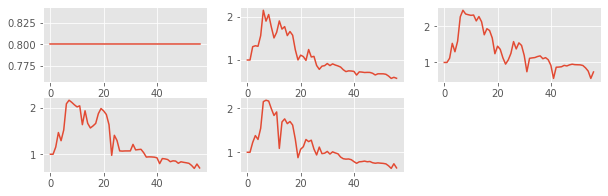

In [103]:
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.subplot(531+i)
    D1 = list(map(lambda s:s[i], Ds))
    plt.plot(D1)

In [148]:
get_param_dists = True
f64 = gpflow.utilities.to_default_float

if get_param_dists:
    #https://mc-stan.org/docs/2_22/stan-users-guide/fit-gp-section.html --> priors for length-scale
    model.kernel.lengthscale.prior = tfd.Gamma(f64(1), f64(1))
    model.likelihood.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
    for D in model.kernel.D:
        D.prior = tfd.Gamma(f64(1), f64(1))#tfd.Normal(f64(D.numpy()), f64(0.12))
    for S in model.kernel.S:
        S.prior = tfd.Gamma(f64(1), f64(1))#tfd.Normal(f64(S.numpy()), f64(0.12))
    for B in model.mean_function.B:
        B.prior = tfd.Gamma(f64(1), f64(1))#tfd.Normal(f64(B.numpy()), f64(0.12))
    print_summary(model)

    num_samples = 200
    num_burnin_steps = 5

    hmc_helper = gpflow.optimizers.SamplingHelper(
        target_log_prob_fn=model.log_marginal_likelihood, 
        model_parameters = model.trainable_parameters
    )

    hmc = mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=hmc_helper.target_log_prob_fn,
        num_leapfrog_steps=5,
        step_size=0.01
    )
    adaptive_hmc = mcmc.SimpleStepSizeAdaptation(
        hmc, #mcmc.TransformedTransitionKernel(, bijectors),
        num_adaptation_steps=int(num_burnin_steps*0.8),
        target_accept_prob=f64(0.75),
        adaptation_rate=0.1
    )
#     adaptive_hmc.bootstrap_results(hmc_helper.current_state)
    
# if False:
    @tf.function
    def run_chain_fn():
#         def trace_fn(something, pkr):
#             print(something)
#             print_summary(model)
#             return pkr.inner_results.is_accepted
        return mcmc.sample_chain(
            num_results=num_samples,
            num_burnin_steps=num_burnin_steps,
            current_state=hmc_helper.current_state,
            kernel=adaptive_hmc,
            trace_fn = lambda _, pkr: pkr.inner_results.is_accepted
        )

    samples, traces = run_chain_fn()
    parameter_samples = hmc_helper.convert_constrained_values(samples)


name                     class      transform    trainable    prior    shape         dtype
-----------------------  ---------  -----------  -----------  -------  -------  ----------
GPR.mean_function.B[0]   Parameter  Chain        True         ()       float64  0.114838
GPR.mean_function.B[1]   Parameter  Chain        True         ()       float64  0.118241
GPR.mean_function.B[2]   Parameter  Chain        True         ()       float64  0.107508
GPR.mean_function.B[3]   Parameter  Chain        True         ()       float64  0.109779
GPR.mean_function.B[4]   Parameter  Chain        True         ()       float64  0.127466
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64  0.321575
GPR.kernel.D[0]          Parameter  Chain        False        ()       float64  0.8
GPR.kernel.D[1]          Parameter  Chain        True         ()       float64  0.578037
GPR.kernel.D[2]          Parameter  Chain        True         ()       float64  0.735773
GPR.kernel.D[3]       

All the Hamiltonian MCMC sampling takes place in an unconstrained space (where constrained parameters have been mapped via a bijector to an unconstrained space). This makes the optimization, as required in the gradient step, much easier.

However, we often wish to sample the constrained parameter values, not the unconstrained one. The SamplingHelper helps us convert our unconstrained values to constrained parameter ones.

In general, adaptation prevents the chain from reaching a stationary distribution, so obtaining consistent samples requires num_adaptation_steps be set to a value somewhat smaller than the number of burnin steps

step_size: Larger step sizes lead to faster progress, but too-large step sizes make rejection exponentially more likely. When possible, it's often helpful to match per-variable step sizes to the standard deviations of the target distribution in each variable

num_leapfrog_steps: Integer number of steps to run the leapfrog integrator for. Total progress per HMC step is roughly proportional to step_size * num_leapfrog_steps.


{'.mean_function.B[0]': 0.01361484159334813, '.mean_function.B[1]': 0.01300900382109649, '.mean_function.B[2]': 0.010339587240868055, '.mean_function.B[3]': 0, '.mean_function.B[4]': 0} [0.042079136405270175, 0.0652965119480599, 0.0007098618621059373, 0.033937366194747215, 0.0004432238400801632]


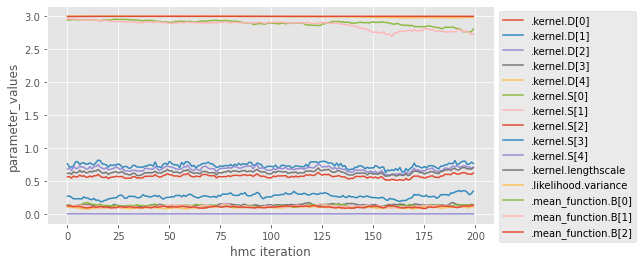

In [149]:
param_to_name = {param: name for name, param in
                 gpflow.utilities.parameter_dict(model).items()}

D_mcmc = {f'.kernel.D[{i}]': 0 for i in range(num_genes)}
S_mcmc = {f'.kernel.S[{i}]':0 for i in range(num_genes)}
B_mcmc = {f'.mean_function.B[{i}]':0 for i in range(num_genes)}
lengthscale = 0

plt.figure(figsize=(8,4))

for val, param in zip(parameter_samples, model.parameters):
    name = param_to_name[param]
    plt.plot(tf.squeeze(val), label=name)

    if 'lengthscale' in name:
        lengthscale = np.std(val)
    elif 'kernel.D' in name:
        D_mcmc[name] = np.std(val)
    elif 'kernel.S' in name:
        S_mcmc[name] = np.std(val)
    elif 'function.B' in name:
        B_mcmc[name] = np.std(val)

plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('hmc iteration')
plt.ylabel('parameter_values');

print(B_mcmc, list(S_mcmc.values()))
# plot_samples(samples, 'unconstrained_variables_values')

c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


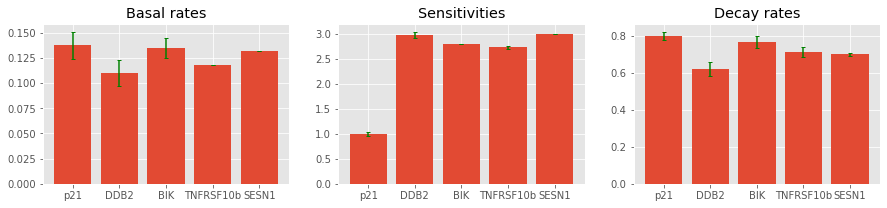

In [151]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
B = [s.numpy() for s in model.mean_function.B]
S = [s.numpy() for s in model.kernel.S]
D = [d.numpy() for d in model.kernel.D]

data = [B, S, D]
vars = [B_mcmc, S_mcmc, D_mcmc]
labels = ['Basal rates', 'Sensitivities', 'Decay rates']

plotnum = 331
for A, var, label in zip(data, vars, labels):
    plt.subplot(plotnum)
    plotnum+=1
    plt.bar(range(5), A, tick_label=genes.index[:num_genes])
    plt.title(label)
    plt.errorbar(range(5), A, yerr=list(var.values()), fmt='none', color='green', capsize=2)
# plt.bar(range(5), S, tick_label=genes.index[:num_genes])
# plt.title('')
# plt.errorbar(range(5), S, list(S_mcmc.values()), color='green')

# plt.subplot(3, 3, 3)
# plt.bar(range(5), D, tick_label=genes.index[:num_genes])
# plt.title()

In [152]:
pred_t = tf.repeat((0, 12, 20), num_genes)
pred_t = np.linspace(0, 12, 20, dtype='float64')
pred_t = np.c_[[pred_t for _ in range(num_genes)]].reshape(-1)

k = model.kernel

K_inv = tf.linalg.inv(k.K(pred_t, None))
Kxf = k.K(pred_t, pred_t)

x = tf.convert_to_tensor(Y) - np.repeat(B/np.array(D), 7).reshape(-1, 1)
print(x.shape)
KfxKxx = tf.matmul(tf.transpose(Kxf), K_inv)
mu_post = tf.matmul(KfxKxx, Y) #replace with x?

print(tf.transpose(Kxf).shape, '*', K_inv.shape,'==', KfxKxx.shape, '*', x.shape)
print('mu shape', mu_post.shape)


K not none K_xf

(35, 1)


InvalidArgumentError: Matrix size-incompatible: In[0]: [20,100], In[1]: [35,1] [Op:MatMul] name: MatMul/

In [257]:


# Kff = k.K_diag(X)
# K_post = Kff - KfxKxx * Kxf
# print('K shape', K_post.shape)

K not none K_xf

(35, 1)
(7, 35) * (35, 35) == (7, 35) * (35, 1)
mu shape (7, 1)


(7,)
[ 0  2  4  6  8 10 12]
range [0.000] 0
sum [-0.23932428813241016]
range [0.000 2.000] 2
sum [-0.23932428813241016, 5.084901153257131]
range [0.000 2.000 4.000] 4
sum [-0.23932428813241016, 5.084901153257131, 45.758960371334545]
range [0.000 2.000 4.000 6.000] 6
sum [-0.23932428813241016, 5.084901153257131, 45.758960371334545, 154.24457370809668]
range [0.000 2.000 4.000 6.000 8.000] 8
sum [-0.23932428813241016, 5.084901153257131, 45.758960371334545, 154.24457370809668, 899.8379707315509]
range [0.000 2.000 4.000 6.000 8.000 10.000] 10
sum [-0.23932428813241016, 5.084901153257131, 45.758960371334545, 154.24457370809668, 899.8379707315509, 256.32455417442026]
range [0.000 2.000 4.000 6.000 8.000 10.000 12.000] 12
sum [-0.23932428813241016, 5.084901153257131, 45.758960371334545, 154.24457370809668, 899.8379707315509, 256.32455417442026, -7124.494392347385]


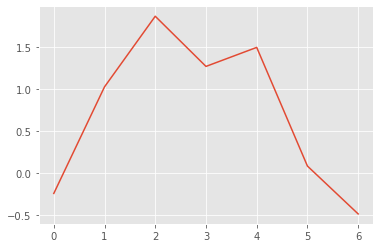

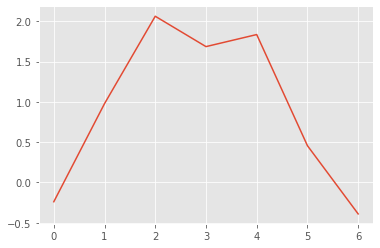

In [258]:
mu = mu_post.numpy().reshape(-1)
print(mu.shape)
plt.plot(mu[:7])
plt.figure()

ts = np.arange(7)*2
print(ts)
x_1 = list()
for t in ts:
    print('range', np.arange(t/2+1)*2, t)
    print('sum', [mu[int(t_/2)]*np.exp(k.D[0]*t_) for t_ in np.arange(t/2+1)*2])
    x_1.append(k.S[0]*np.exp(-k.D[0]*t)*np.sum([mu[int(t_/2)]*np.exp(k.D[0]*t_) for t_ in np.arange(t/2+1)*2]))
plt.plot(x_1)

<Figure size 432x288 with 0 Axes>

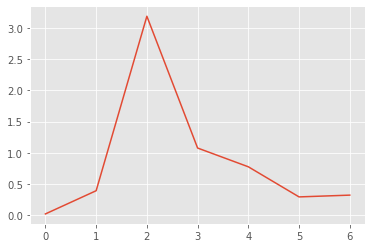

<Figure size 432x288 with 0 Axes>

In [253]:
plt.plot(Y[:7])
plt.figure()

In [27]:
mean, var = model.predict_f(X)
mean

k_diag
K not none K_xf

err shape (35, 1)


InvalidArgumentError: Incompatible shapes: [35] vs. [7] [Op:Sub] name: sub/

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(mean)
plt.subplot(2, 2, 2)
plt.plot(genes[genes.index == 'p53'].values[0])

k_diag


<tf.Tensor: shape=(35,), dtype=float64, numpy=
array([1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000,
       1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000,
       1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000,
       1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000])>

## Non-linear response
    